In [211]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import Lasso

import scipy as sp
from scipy.stats import skew, norm
from scipy.optimize import minimize


In [212]:
data = pd.read_csv('households_data.csv',sep=',',header='infer')
data.head()

,loan,hh,village,religion,roof,rooms,beds,electricity,ownership,leader,connections
0,0,1001,1,hindu,tile,3,4,0,OWNED,0,10
1,0,1002,1,hindu,tile,1,1,1,OWNED,1,14
2,0,1003,1,hindu,rcc,3,4,1,OWNED,1,4
3,0,1004,1,hindu,tile,2,6,1,OWNED,0,8
4,0,1005,1,hindu,tile,3,4,1,OWNED,0,16


In [213]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8622 entries, 0 to 8621
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   loan         8622 non-null   int64 
 1   hh           8622 non-null   int64 
 2   village      8622 non-null   int64 
 3   religion     8622 non-null   object
 4   roof         8622 non-null   object
 5   rooms        8622 non-null   int64 
 6   beds         8622 non-null   int64 
 7   electricity  8622 non-null   int64 
 8   ownership    8622 non-null   object
 9   leader       8622 non-null   int64 
 10  connections  8622 non-null   int64 
dtypes: int64(8), object(3)
memory usage: 741.1+ KB


## Question 1

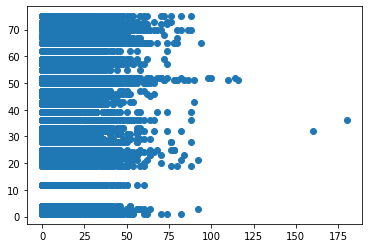

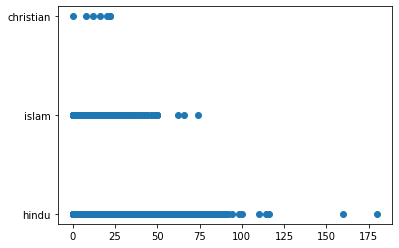

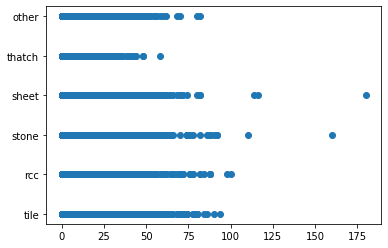

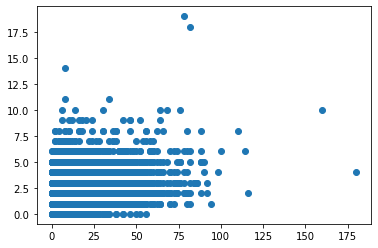

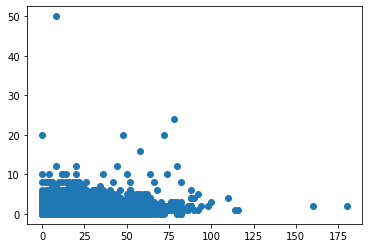

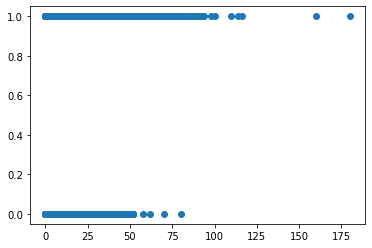

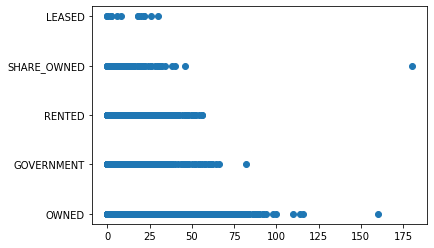

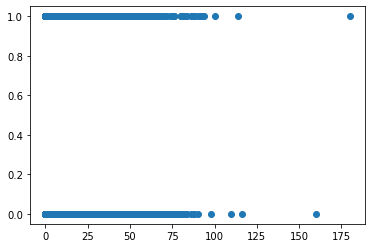

In [214]:
## plot connections and loans to find the most suitable transformation
# log transformation for connections is more proper as the plots show
for i in range(2,10):
    #x = df['connections'].apply(lambda x: np.log(x+1))
    x = data['connections']
    y = data.iloc[:,i]    
    plt.figure()
    plt.scatter(x,y)

(array([4.676e+03, 2.748e+03, 9.460e+02, 1.900e+02, 5.000e+01, 7.000e+00,
        3.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([  0.,  18.,  36.,  54.,  72.,  90., 108., 126., 144., 162., 180.]),
 <a list of 10 Patch objects>)

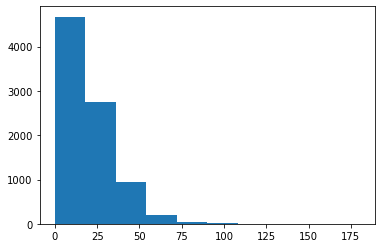

In [215]:
plt.hist(data['connections'])

In [216]:
#transform degree, log is good for variables that are higly skewed
data['d'] = data['connections'].apply(lambda x: np.log(x+1))

(array([ 449.,    0.,  567., 1212., 1611., 1603., 2147.,  933.,   95.,
           5.]),
 array([0.        , 0.5198497 , 1.03969941, 1.55954911, 2.07939881,
        2.59924852, 3.11909822, 3.63894792, 4.15879763, 4.67864733,
        5.19849703]),
 <a list of 10 Patch objects>)

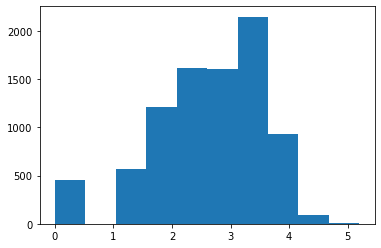

In [217]:
plt.hist(data['d'])

In [218]:
# Create dummy variables for qualitative columns
data = pd.get_dummies(data)

# Dropping one dummy 
del data['religion_christian']
del data['roof_other']
del data['ownership_GOVERNMENT']

In [219]:
data.head()

,loan,hh,village,rooms,beds,electricity,leader,connections,d,religion_hindu,religion_islam,roof_rcc,roof_sheet,roof_stone,roof_thatch,roof_tile,ownership_LEASED,ownership_OWNED,ownership_RENTED,ownership_SHARE_OWNED
0,0,1001,1,3,4,0,0,10,2.397895,1,0,0,0,0,0,1,0,1,0,0
1,0,1002,1,1,1,1,1,14,2.708050,1,0,0,0,0,0,1,0,1,0,0
2,0,1003,1,3,4,1,1,4,1.609438,1,0,1,0,0,0,0,0,1,0,0
3,0,1004,1,2,6,1,0,8,2.197225,1,0,0,0,0,0,1,0,1,0,0
4,0,1005,1,3,4,1,0,16,2.833213,1,0,0,0,0,0,1,0,1,0,0


## Question 2

In [220]:
# Deleting house number column since it is just an identifier and does not provide any real value to the dataset
del data['hh']

In [221]:
# Getting a list of all the columng in the database
list = data.select_dtypes(exclude=['object']).columns
list

Index(['loan', 'village', 'rooms', 'beds', 'electricity', 'leader',
       'connections', 'd', 'religion_hindu', 'religion_islam', 'roof_rcc',
       'roof_sheet', 'roof_stone', 'roof_thatch', 'roof_tile',
       'ownership_LEASED', 'ownership_OWNED', 'ownership_RENTED',
       'ownership_SHARE_OWNED'],
      dtype='object')

In [222]:
# VIF to check correlations 
df = data

# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = df.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(df.values, i) 
                          for i in range(len(df.columns))] 
print(vif_data)

                  feature        VIF
0                    loan   1.188905
1                 village   5.365857
2                   rooms   5.927989
3                    beds   1.778555
4             electricity  15.403784
5                  leader   1.175956
6             connections   9.730403
7                       d  30.540059
8          religion_hindu  69.296135
9          religion_islam   4.607883
10               roof_rcc   3.414717
11             roof_sheet   5.002594
12             roof_stone   6.969053
13            roof_thatch   1.506377
14              roof_tile   8.226127
15       ownership_LEASED   1.059983
16        ownership_OWNED  30.530366
17       ownership_RENTED   2.639898
18  ownership_SHARE_OWNED   1.299243


In [223]:
# Create interaction terms between independent variables 
df_interactions = data.drop(['connections','loan', 'd'], axis=1)

In [224]:
# Processing interaction terms upto third degree (~.^3)
poly = preprocessing.PolynomialFeatures(3, interaction_only=False, include_bias=False)
data_array = poly.fit_transform(df_interactions)

target_feature_names = ['_x_'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(df_interactions.columns,p) for p in poly.powers_]]
data_interaction = pd.DataFrame(data_array, columns = target_feature_names)

In [225]:
data_interaction.head()

,village^1,rooms^1,beds^1,electricity^1,leader^1,religion_hindu^1,religion_islam^1,roof_rcc^1,roof_sheet^1,roof_stone^1,...,ownership_OWNED^3,ownership_OWNED^2_x_ownership_RENTED^1,ownership_OWNED^2_x_ownership_SHARE_OWNED^1,ownership_OWNED^1_x_ownership_RENTED^2,ownership_OWNED^1_x_ownership_RENTED^1_x_ownership_SHARE_OWNED^1,ownership_OWNED^1_x_ownership_SHARE_OWNED^2,ownership_RENTED^3,ownership_RENTED^2_x_ownership_SHARE_OWNED^1,ownership_RENTED^1_x_ownership_SHARE_OWNED^2,ownership_SHARE_OWNED^3
0,1.0,3.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,3.0,4.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,2.0,6.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,3.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [226]:
#then use lasso to predict degree with above interactions
lasso = Lasso(alpha=0.1)
model_lasso = lasso.fit(data_interaction, data['d'])
# R-Squared for the above interaction model
model_lasso.score(data_interaction, data['d'])

0.06911745914354128

## Question 3

In [227]:
# Look at the remaining terms(coef is not 0)
table = pd.DataFrame({'columns':data_interaction.columns, 'coef':model_lasso.coef_})
left_variables = table[table['coef']!=0]
left_variables

,columns,coef
16,village^2,-0.000177
17,village^1_x_rooms^1,0.003268
20,village^1_x_leader^1,0.006283
152,village^3,0.000006
153,village^2_x_rooms^1,-0.000028
154,village^2_x_beds^1,0.000019
155,village^2_x_electricity^1,-0.000067
156,village^2_x_leader^1,-0.000154
157,village^2_x_religion_hindu^1,-0.000217
158,village^2_x_religion_islam^1,-0.000212


In [228]:
# Create dhat and d in the data frame
dhat = model_lasso.predict(data_interaction)
data_interaction['d']= data['d']
data_interaction['dhat'] = dhat

In [229]:
# Get the location of 
data_interaction.columns.get_loc('dhat')

969

In [230]:
# Define the Independent variable (loan)
loan = data['loan']

In [231]:
# Define lasso function first
def lasso(x):
    return (1. / (2 * data_interaction.shape[0])) * np.square(np.linalg.norm(data_interaction.dot(x) - loan, 2)) + 0.1 * np.linalg.norm(weights*x, 1)

In [232]:
# Setting weights
weights = np.ones(data_interaction.shape[1])

In [233]:
# Set weight of d and dhat to 0
weights [969] = 0
weights [968] = 0
weights

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [234]:
x0 = np.zeros(data_interaction.shape[1])
res = minimize(lasso, x0, method='L-BFGS-B', options={'disp': False})

In [235]:
print(res.x)

[ 2.86248042e-06  3.74205557e-08  1.16813279e-07  1.47092945e-07
  3.07571918e-08  1.40072445e-07  2.72511912e-08  1.54476130e-08
  3.55642343e-08  6.10925828e-08  8.17617276e-09  4.39592230e-08
  2.65296165e-09  1.38836628e-07  1.53175756e-08  4.70024446e-09
  5.85572576e-05  4.21300043e-06  1.03598450e-06  2.28420797e-06
  4.22225954e-07  2.01791960e-06  5.64754337e-07  2.33642761e-07
  3.50665755e-07  7.62873495e-07  1.48211863e-07  5.68895493e-07
  4.09540322e-08  2.07041072e-06  3.69125006e-07  6.08928332e-08
  4.23650331e-07  3.17254853e-08  1.03413114e-08  5.26836096e-08
 -1.61953806e-08  5.47202183e-08  3.65734054e-08  5.83444168e-08
  8.76577211e-09  8.87513818e-09  6.64641236e-08  2.91704818e-09
 -2.08504813e-08  2.74827601e-08  1.14536652e-08  4.11034652e-08
 -4.54122850e-09  2.44428119e-08 -1.09696049e-08  1.74569039e-08
  2.65234436e-08  2.59915793e-08  4.15595026e-08  2.06796028e-09
  3.00331080e-08  2.06093775e-09  9.57387059e-08  9.67817191e-09
  9.12576043e-09  1.47092

In [236]:
coef_df = pd.DataFrame({'columns':data_interaction.columns, 'coef':res.x})
coef_df

,columns,coef
0,village^1,2.862480e-06
1,rooms^1,3.742056e-08
2,beds^1,1.168133e-07
3,electricity^1,1.470929e-07
4,leader^1,3.075719e-08
...,...,...
965,ownership_RENTED^2_x_ownership_SHARE_OWNED^1,1.896247e-09
966,ownership_RENTED^1_x_ownership_SHARE_OWNED^2,1.896247e-09
967,ownership_SHARE_OWNED^3,4.700244e-09
968,d,4.504973e-07


In [237]:
# set threhold of 0.0000001 for coefficient to eliminate variables
coef_df['coef']=coef_df['coef'].apply(lambda x: x if x > 0.0000001 else 0)
coef_df

,columns,coef
0,village^1,2.862480e-06
1,rooms^1,0.000000e+00
2,beds^1,1.168133e-07
3,electricity^1,1.470929e-07
4,leader^1,0.000000e+00
...,...,...
965,ownership_RENTED^2_x_ownership_SHARE_OWNED^1,0.000000e+00
966,ownership_RENTED^1_x_ownership_SHARE_OWNED^2,0.000000e+00
967,ownership_SHARE_OWNED^3,0.000000e+00
968,d,4.504973e-07


In [238]:
left_variables = coef_df[coef_df['coef']!=0]
left_variables

,columns,coef
0,village^1,2.862480e-06
2,beds^1,1.168133e-07
3,electricity^1,1.470929e-07
5,religion_hindu^1,1.400724e-07
13,ownership_OWNED^1,1.388366e-07
...,...,...
690,religion_hindu^2_x_ownership_OWNED^1,1.177756e-07
742,religion_hindu^1_x_ownership_OWNED^2,1.177756e-07
958,ownership_OWNED^3,1.388366e-07
968,d,4.504973e-07


In [239]:
#model prediction
# calculate loan_prospensity_pred
loan_prospensity_pred = data_interaction.dot(coef_df.set_index('columns'))
loan_prospensity_pred

,coef
0,0.000355
1,0.000231
2,0.000431
3,0.000438
4,0.000416
...,...
8617,0.876659
8618,0.734446
8619,0.874367
8620,0.993567


In [240]:
#set threhold for loan prospensity 0.6

loan_pred = pd.DataFrame(np.where(loan_prospensity_pred > 0.5, 1, 0))
loan_pred

,0
0,0
1,0
2,0
3,0
4,0
...,...
8617,1
8618,1
8619,1
8620,1


In [241]:
loan_pred[0].value_counts()

0    6247
1    2375
Name: 0, dtype: int64

In [242]:
loan.value_counts()

0    7367
1    1255
Name: loan, dtype: int64

[[5318 2049]
 [ 929  326]]
[[5318 2049]
 [ 929  326]]


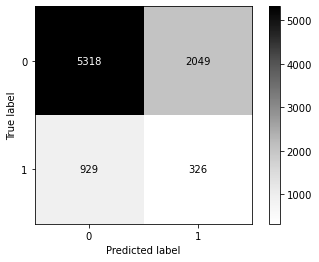

In [243]:
# plot confusion matrix
from sklearn import metrics
cm = metrics.confusion_matrix(loan, loan_pred)
print(cm)
diagram = metrics.ConfusionMatrixDisplay(cm,display_labels=None)
diagram.plot(cmap = 'Greys')
print(cm)

In [244]:
mse_score = np.mean((loan_prospensity_pred - loan)**2)
mse_score

coef   NaN
0      NaN
1      NaN
2      NaN
3      NaN
        ..
8617   NaN
8618   NaN
8619   NaN
8620   NaN
8621   NaN
Length: 8623, dtype: float64

In [245]:
from sklearn.metrics import mean_squared_error 
mean_squared_error(loan,loan_prospensity_pred) 


0.23292874394259863

In [246]:
std_error = np.std(loan_prospensity_pred)/(len(loan_prospensity_pred) ** 0.5)
std_error

coef    0.002864
dtype: float64

## Question 4

### Naive Lasso - lienar regression

In [247]:
## naive lasso

## create new independent variable set without dhat

loan = data['loan']
data_naive = data_interaction.drop(columns=['dhat'])

#70% records being sent into training set 
pts = np.random.rand(len(data_naive)) < 0.7

data_naive_train = data_naive[pts]
data_naive_test = data_naive[~pts]

loan_train = loan[pts]
loan_test = loan[~pts]

In [248]:
clf = Lasso(alpha=0.1)
clf.fit(data_naive_train,loan_train)


Lasso(alpha=0.1)

In [249]:
# Look at the remaining terms(coef is not 0)
table_naive_lasso = pd.DataFrame({'columns':data_naive.columns, 'coef':clf.coef_})
left_variables_naive_lasso = table_naive_lasso[table_naive_lasso['coef']!=0]
left_variables_naive_lasso

,columns,coef
16,village^2,-2.735389e-05
152,village^3,4.089496e-07
153,village^2_x_rooms^1,-4.816125e-07
154,village^2_x_beds^1,-3.825719e-06
155,village^2_x_electricity^1,4.724465e-06
156,village^2_x_leader^1,1.889961e-05
157,village^2_x_religion_hindu^1,-1.333320e-05
158,village^2_x_religion_islam^1,2.121061e-05
159,village^2_x_roof_rcc^1,3.176412e-07
160,village^2_x_roof_sheet^1,1.057100e-05


In [250]:
# predict loan using naive lasso 
predicted_loan_naivelasso = clf.predict(data_naive_test)
predicted_loan_naivelasso

array([0.17693075, 0.17729322, 0.17664189, ..., 0.07425361, 0.08580665,
       0.14986962])

In [251]:
loan_pred = pd.DataFrame(np.where(predicted_loan_naivelasso > 0.5, 1, 0))
loan_pred

,0
0,0
1,0
2,0
3,0
4,0
...,...
2571,0
2572,0
2573,0
2574,0


[[2194    2]
 [ 380    0]]
[[2194    2]
 [ 380    0]]


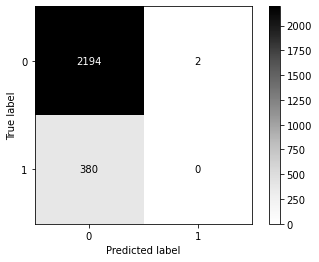

In [252]:
## take a look at confusion matrix
from sklearn import metrics
cm = metrics.confusion_matrix(loan_test, loan_pred)
print(cm)
diagram = metrics.ConfusionMatrixDisplay(cm,display_labels=None)
diagram.plot(cmap = 'Greys')
print(cm)

In [253]:
mean_squared_error(loan_test,predicted_loan_naivelasso) 


0.12549730817269555

In [254]:
std_error = np.std(predicted_loan_naivelasso)/(len(predicted_loan_naivelasso) ** 0.5)
std_error

0.0008580779404803622

## Question 5_Bootstrap

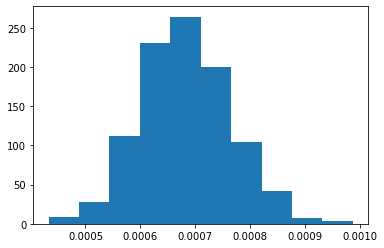

95% confidence interval 0.000521 and 0.000851


In [188]:
from sklearn.utils import resample
from matplotlib import pyplot
import warnings
warnings.filterwarnings('ignore')

# Loading a combined dataset (y,x,d,dhat)
data_bootstrap = pd.DataFrame.copy(data_interaction)
data_bootstrap['loan'] = data['loan']
values = data_bootstrap.values

# Configuring bootstrap
n_iterations = 1000
n_size = int(len(data_bootstrap) * 0.50)
# Running the bootstrap
stats = []
for i in range(n_iterations):
    # Fitting the Lasso model on the sample
    data_sample = resample(values, n_samples=n_size)
    model = Lasso(alpha=0.1)
    X = data_sample[:,:-1]
    y = data_sample[:,-1]
    model_boot = model.fit(X, y)
    # Evaluate the model
    predictions = model_boot.predict(X)
    #mse_score = np.mean((predictions - y)**2)
    std_error = np.std(predictions)/(len(predictions) ** 0.5)
    #print(std_error)
    stats.append(std_error)
# Plotting the measure
pyplot.hist(stats)
pyplot.show()
# Confidence Intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats, p))
print('%.i%% confidence interval %.6f and %.6f' % (alpha*100, lower, upper))